In [4]:
%matplotlib inline

In [5]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import glob

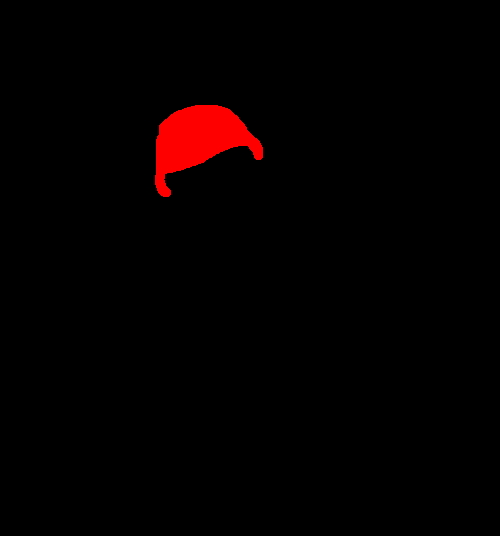

In [6]:
mask = Image.open('data/object-detect/test2/masks/u-21903147-4293534171.png')
# print(np.array(mask).tolist())
# each mask instance has a different color, from zero to N, where
# N is the number of instances. In order to make visualization easier,
# let's adda color palette to the mask.
mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
])
mask

In [7]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(glob.glob(os.path.join(root, "images/*.jpeg"))))
        self.masks = list(sorted(glob.glob(os.path.join(root, "masks/*.png"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = self.imgs[idx]
        mask_path = self.masks[idx]
#         print('image', img_path)
#         print('mask', mask_path)
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        
        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
#         print('obj_ids', obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target

    def __len__(self):
        return len(self.imgs)

In [8]:
dataset = PennFudanDataset('data/object-detect/test2/')
dataset[0]

(<PIL.Image.Image image mode=RGB size=500x686 at 0x12029ADA0>,
 {'boxes': tensor([[142.,  73., 197., 105.]]),
  'labels': tensor([1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'image_id': tensor([0]),
  'area': tensor([1760.]),
  'iscrowd': tensor([0])})

In [9]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [10]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [11]:
# use our dataset and defined transformations
dataset = PennFudanDataset('data/object-detect/test2', get_transform(train=True))
dataset_test = PennFudanDataset('data/object-detect/test2', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=1,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=1,
    collate_fn=utils.collate_fn)


In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [13]:
# let's train it for 10 epochs
num_epochs = 1

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/152]  eta: 1:27:12  lr: 0.000038  loss: 4.8003 (4.8003)  loss_classifier: 0.9397 (0.9397)  loss_box_reg: 0.0532 (0.0532)  loss_mask: 3.7027 (3.7027)  loss_objectness: 0.0917 (0.0917)  loss_rpn_box_reg: 0.0131 (0.0131)  time: 34.4225  data: 0.1927
Epoch: [0]  [ 10/152]  eta: 1:48:30  lr: 0.000369  loss: 3.1928 (3.3675)  loss_classifier: 0.6853 (0.6359)  loss_box_reg: 0.0530 (0.0528)  loss_mask: 2.4042 (2.5519)  loss_objectness: 0.0655 (0.1152)  loss_rpn_box_reg: 0.0070 (0.0118)  time: 45.8465  data: 0.0238
Epoch: [0]  [ 20/152]  eta: 1:43:08  lr: 0.000700  loss: 1.7103 (2.3281)  loss_classifier: 0.1613 (0.3788)  loss_box_reg: 0.0411 (0.0472)  loss_mask: 1.1543 (1.8025)  loss_objectness: 0.0643 (0.0895)  loss_rpn_box_reg: 0.0070 (0.0101)  time: 47.5091  data: 0.0074
Epoch: [0]  [ 30/152]  eta: 1:36:27  lr: 0.001030  loss: 0.8092 (1.8374)  loss_classifier: 0.1067 (0.3031)  loss_box_reg: 0.0477 (0.0590)  loss_mask: 0.5537 (1.3763)  loss_objectness: 0.0668 (0.0885)  loss_rp

IndexError: too many indices for tensor of dimension 1

In [14]:
# pick one image from the test set
img, _ = dataset_test[0]
print(img)
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

tensor([[[0.6549, 0.8392, 0.9059,  ..., 0.7176, 0.6784, 0.6000],
         [0.6784, 0.8627, 0.9176,  ..., 0.6627, 0.6353, 0.5725],
         [0.7216, 0.9020, 0.9373,  ..., 0.6078, 0.5725, 0.5294],
         ...,
         [0.1137, 0.1176, 0.1333,  ..., 0.0118, 0.0196, 0.0275],
         [0.0863, 0.0902, 0.0980,  ..., 0.0196, 0.0314, 0.0431],
         [0.0588, 0.0627, 0.0706,  ..., 0.0275, 0.0431, 0.0549]],

        [[1.0000, 1.0000, 0.8941,  ..., 0.2510, 0.3059, 0.3333],
         [0.9804, 1.0000, 0.9059,  ..., 0.2627, 0.3216, 0.3569],
         [0.9020, 1.0000, 0.9294,  ..., 0.2980, 0.3490, 0.3922],
         ...,
         [0.1176, 0.1216, 0.1333,  ..., 0.0118, 0.0196, 0.0275],
         [0.0824, 0.0902, 0.1020,  ..., 0.0196, 0.0314, 0.0431],
         [0.0549, 0.0549, 0.0706,  ..., 0.0275, 0.0431, 0.0549]],

        [[0.9451, 1.0000, 0.9765,  ..., 0.1647, 0.2275, 0.2588],
         [0.9176, 1.0000, 0.9725,  ..., 0.1647, 0.2314, 0.2784],
         [0.8510, 0.9882, 0.9725,  ..., 0.1804, 0.2431, 0.

In [15]:
prediction

[{'boxes': tensor([[2.8601e+02, 1.8937e+01, 3.5128e+02, 6.3117e+01],
          [1.5979e+02, 3.7354e+01, 2.8441e+02, 1.5672e+02],
          [4.8282e+00, 1.8599e+02, 1.3774e+02, 3.2828e+02],
          [2.6514e+02, 4.7304e+01, 3.0027e+02, 9.9618e+01],
          [1.6032e+02, 4.8998e+01, 1.9457e+02, 7.9253e+01],
          [2.6278e+02, 1.2605e+01, 3.6338e+02, 7.1337e+01],
          [1.6899e+01, 2.0305e+02, 6.4294e+01, 2.5800e+02],
          [2.0409e+02, 9.2766e+01, 2.7353e+02, 1.6212e+02],
          [2.3645e+02, 1.9866e+02, 2.8107e+02, 2.2951e+02],
          [8.0994e+00, 1.6794e+02, 1.5781e+02, 2.7370e+02],
          [1.1211e+01, 2.4119e+02, 1.1847e+02, 3.2861e+02],
          [2.8639e+01, 7.0934e+01, 4.4908e+01, 9.3819e+01],
          [3.7043e+02, 1.7249e-01, 3.9608e+02, 3.0306e+01],
          [2.1741e+02, 1.7543e+01, 3.6062e+02, 9.2617e+01],
          [1.1736e+00, 4.4218e+01, 3.0462e+02, 2.2176e+02],
          [3.8237e+00, 8.4441e+01, 1.3074e+02, 2.0197e+02],
          [2.7429e+02, 4.0783e+

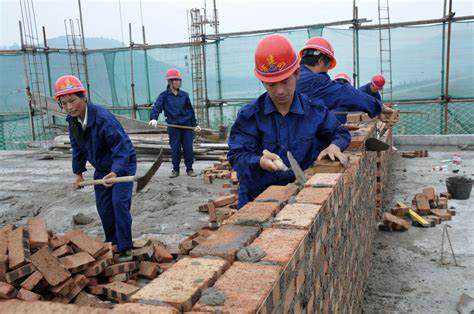

In [64]:
transform = T.Compose([
        T.ToTensor(),
    ])

img = Image.open('data/workers1.jpg').convert("RGB")
inputs, _ = transform(img, {})
prediction = model([inputs])
img

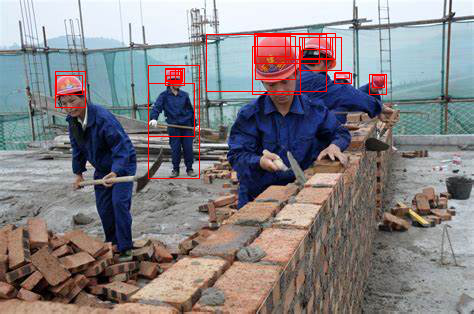

In [74]:
from PIL import Image, ImageDraw

draw = ImageDraw.Draw(img)

for r in prediction[0]['boxes']:
#     print(r.detach().numpy())
    draw.rectangle(r.detach().numpy(), outline='red')

img

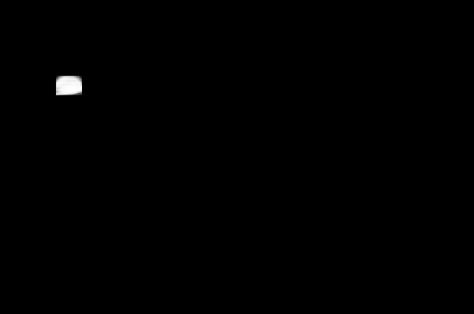

In [62]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy(), mode='L')